In [87]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

`Problem Statement`
Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

# read data

In [88]:
data = pd.read_csv('ola_driver_scaler.csv')
data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [89]:
# drop columns Unnamed: 0
data.drop('Unnamed: 0',axis=1,inplace=True)
print(f"shape of daata is {data.shape}")

shape of daata is (19104, 13)


In [90]:
# Missing values
data.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [91]:
# datatype  transformations
cols =['MMM-YY', 'Dateofjoining' ,'LastWorkingDate']
# convert columns to datetime 
for c in cols:
    data[c]=pd.to_datetime(data[c])  

In [92]:
data['MMM-YY_year'] =data['MMM-YY'].dt.year
data['MMM-YY_month'] =data['MMM-YY'].dt.month
data['MMM-YY_quarter'] =data['MMM-YY'].dt.quarter


data['target'] = data['LastWorkingDate'].isna().astype(int)
# if LastWorkingDate is not null then 1 else 0
data['target'] = data['target'].apply(lambda x:0 if x==1 else 1)
# has Quarterly Rating  increased 

def has_quarterly_rating_increased(x):
    ser = x['Quarterly Rating']
    x['has_quartery_rating_increased'] =   (1 if ser.max() > ser.min() else 0)
    return x
data =data.groupby('Driver_ID').apply( lambda x: has_quarterly_rating_increased(x) ).reset_index(drop=True)


def has_Income_increased(x):
    ser = x['Income']
    x['has_Income_increased'] =   (1 if ser.max() > ser.min() else 0)
    return x
data =data.groupby('Driver_ID').apply( lambda x: has_Income_increased(x) ).reset_index(drop=True)

proxy_date_of_exit = data['LastWorkingDate'].max()
data['LastWorkingDate_temp'] =data['LastWorkingDate'].copy(deep=True)
data['LastWorkingDate_temp'].fillna(proxy_date_of_exit , inplace=True)
# extract days data['LastWorkingDate_temp'] - data['Dateofjoining'] difference
data['length_of_stay']=(data['LastWorkingDate_temp'] - data['Dateofjoining']).dt.days

data.drop(['LastWorkingDate_temp'], axis=1, inplace=True)

data['doj_year'] =data['Dateofjoining'].dt.year
data['doj_month'] =data['Dateofjoining'].dt.month
data['doj_quater'] =data['Dateofjoining'].dt.quarter


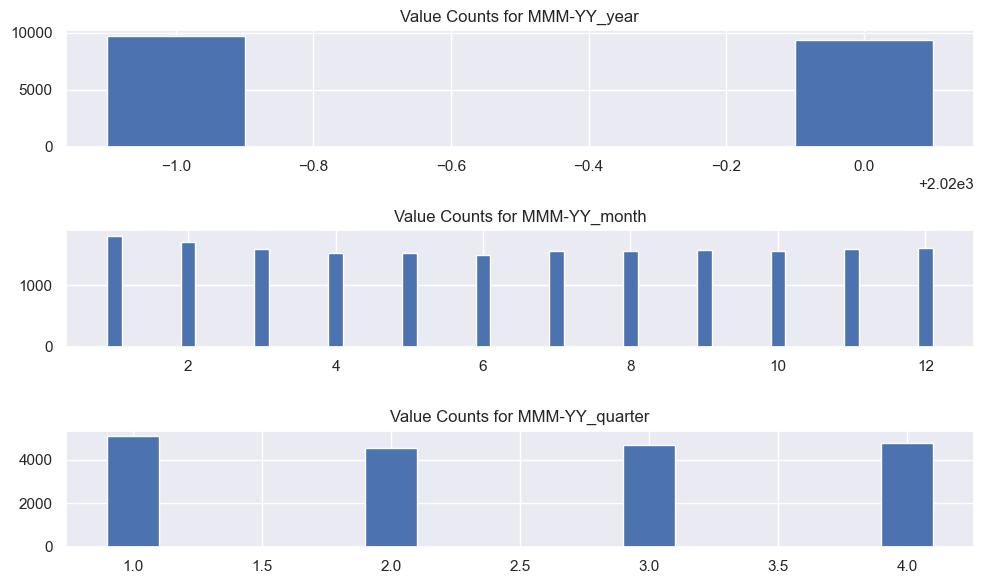

In [93]:

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, figsize=(10, 6))

# Plot the value counts for 'MMM-YY_year'
axs[0].bar(data['MMM-YY_year'].value_counts().index, data['MMM-YY_year'].value_counts() ,width=0.2)
axs[0].set_title('Value Counts for MMM-YY_year')

# Plot the value counts for 'MMM-YY_month'
axs[1].bar(data['MMM-YY_month'].value_counts().index, data['MMM-YY_month'].value_counts(),width=0.2)
axs[1].set_title('Value Counts for MMM-YY_month')

# Plot the value counts for 'MMM-YY_quarter'
axs[2].bar(data['MMM-YY_quarter'].value_counts().index, data['MMM-YY_quarter'].value_counts(),width=0.2)
axs[2].set_title('Value Counts for MMM-YY_quarter')

# Set labels and layout
plt.tight_layout()
plt.show()

* No of driver that reported in 2019 (9708) is more than in 2020 (9396)
* Most driver reported for months january , feb and dec , in between month no of repost keeps on droping 
* In first quarter most of driver reported lest is on quarter 2 


In [94]:
# drop columns
data.drop(columns=['MMM-YY_year' ,'MMM-YY_month' ,'MMM-YY_quarter'],inplace=True , axis=1)

In [95]:
cat =['Education_Level' ,'Grade','Joining Designation' ,'Gender' ]
date =['Dateofjoining' ,'LastWorkingDate' ,]
num =['Age','Income','Quarterly Rating' ]

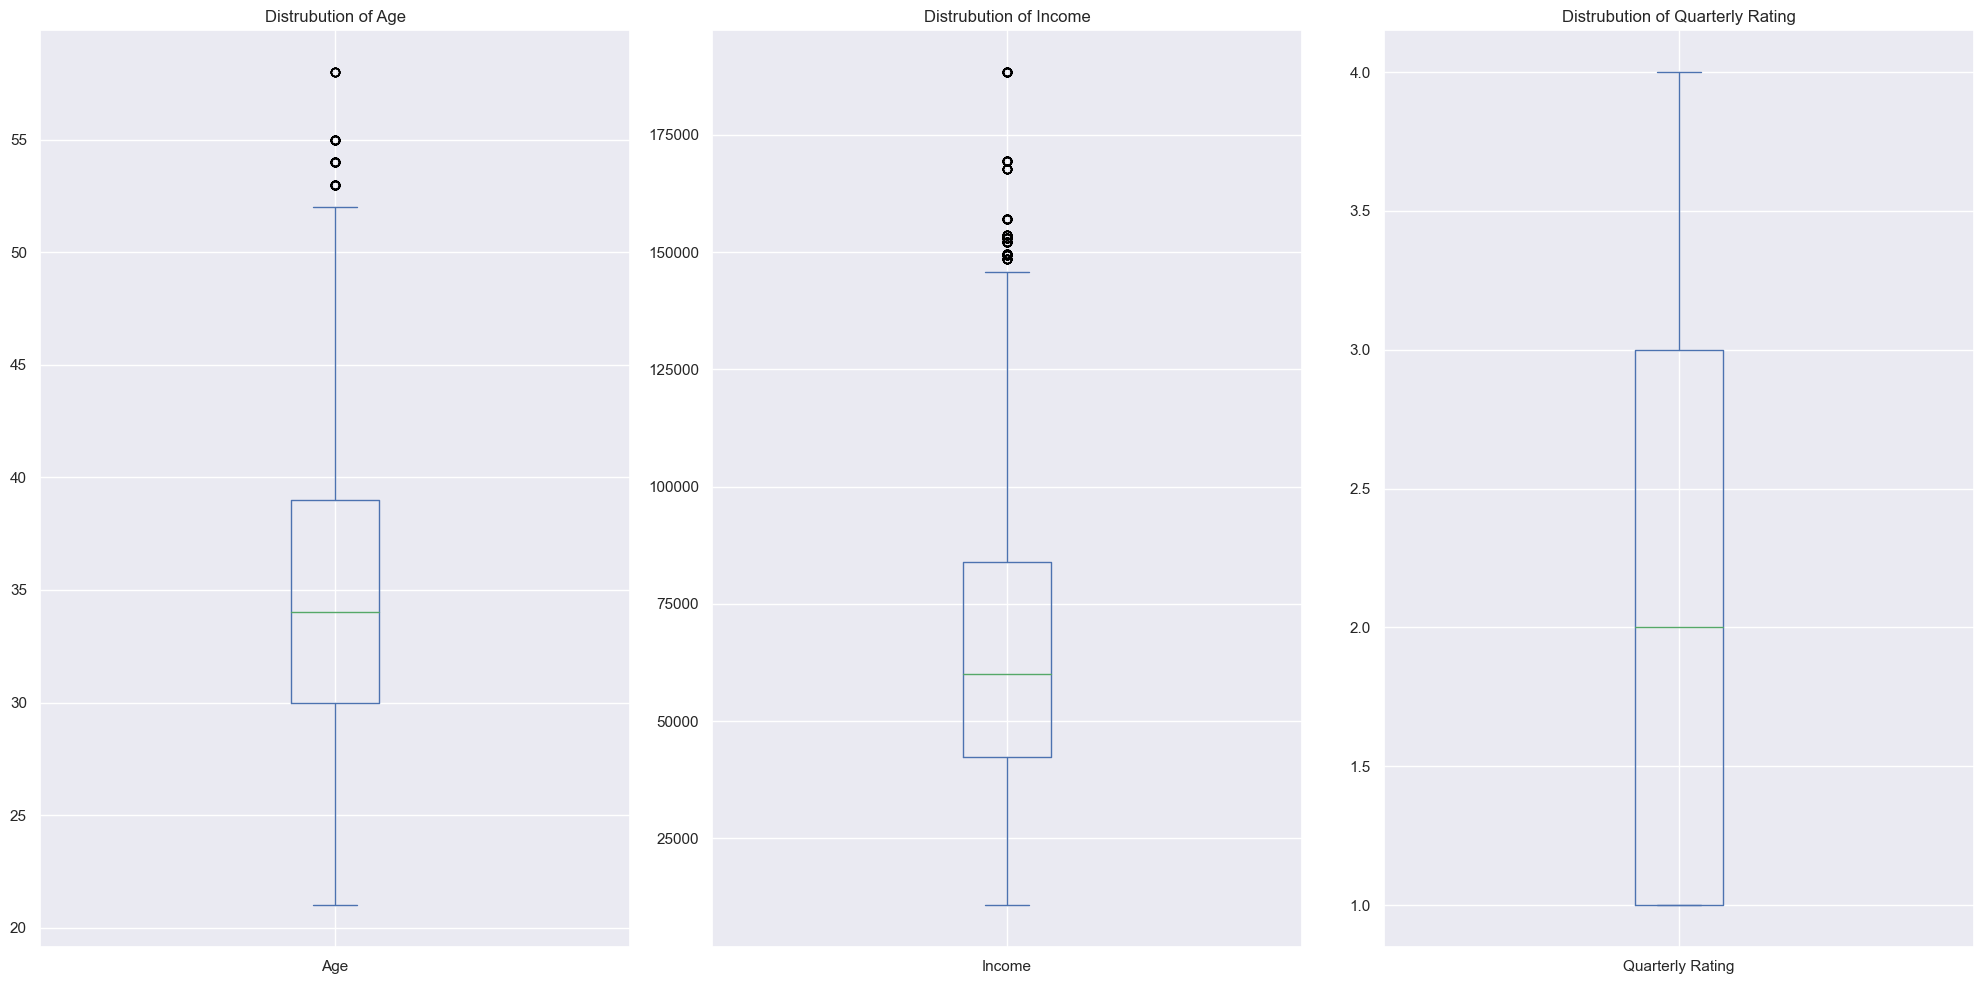

In [96]:
fig , ax = plt.subplots(1,3,figsize=(20,10))
ax = ax.flatten()
for i,col in  enumerate(num):
    data[col].plot(kind='box' , ax=ax[i])
    ax[i].set_title("Distrubution of " + col)

plt.tight_layout()
plt.show()  

* Median/mean age of driver is around 34 minimun age is 21 and max 58 
* Mean Income is around 65000 and max 188000
* Median driver rating is 2 min is 1 and max is 4 

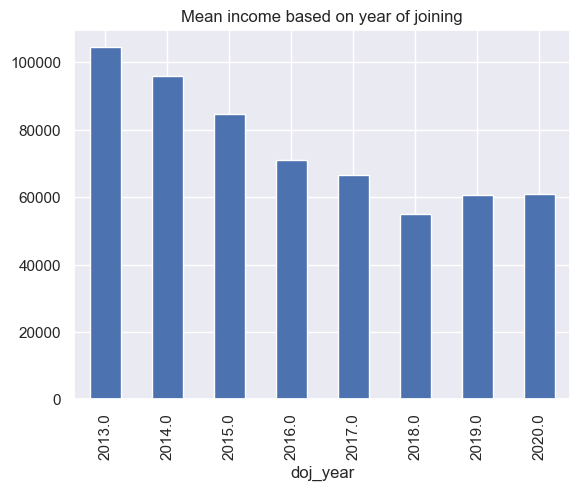

In [176]:
data.groupby('doj_year')['Income'].mean().plot(kind='bar')
plt.title('Mean income based on year of joining')
plt.show()

* year on year mean income is falling 2018 was the lowest , mean income seem to stagnate post 2019

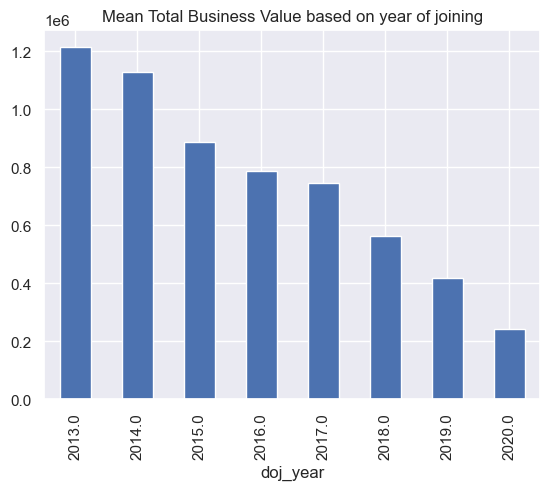

In [177]:
data.groupby('doj_year')['Total Business Value'].mean(
    
).plot(kind='bar')
plt.title('Mean Total Business Value based on year of joining')
plt.show()


* year on year mean Total Business Value falling

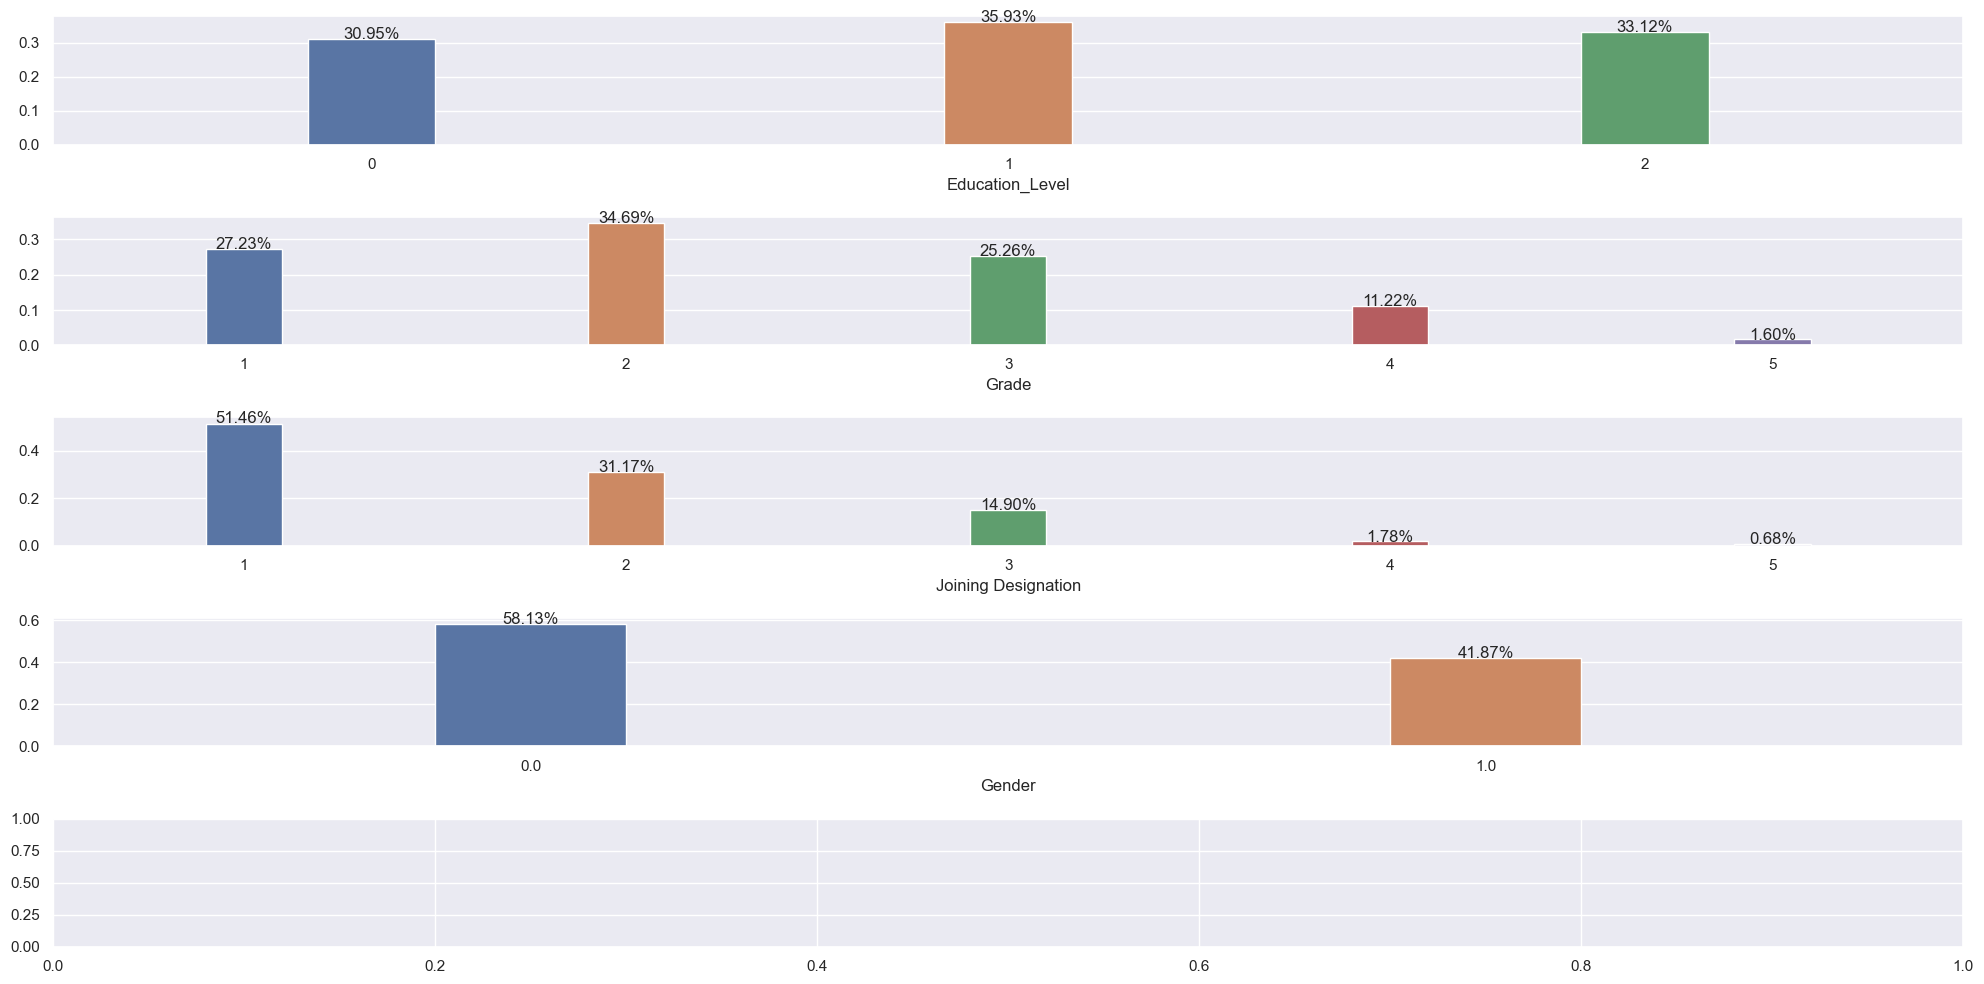

In [97]:


fig, ax = plt.subplots(5, 1, figsize=(20, 10))
ax = ax.flatten()

for i, col in enumerate(cat):
    values = data[col].value_counts(normalize=True )
    sns.barplot(x=values.index, y=values.values, ax=ax[i] , width=0.2 )
    for p in ax[i].patches:
        height = p.get_height()
        ax[i].text(p.get_x() + p.get_width()/2, 
                    1.005*height, f'{height:.2%}', ha='center')

plt.tight_layout()
plt.show()


* Most common edcation level is 1 about 36% 
* Most common grade is  2 about 35% least common is 5 about 2%
* Most common designation is 1 about 51% 
* most common gender is 0 about 58% and 1 with 42%
* Target is imbalance with 8% where attrition =1 and 92% where there is no attrition =0  

In [98]:
num.append('Total Business Value')
num.append('length_of_stay')

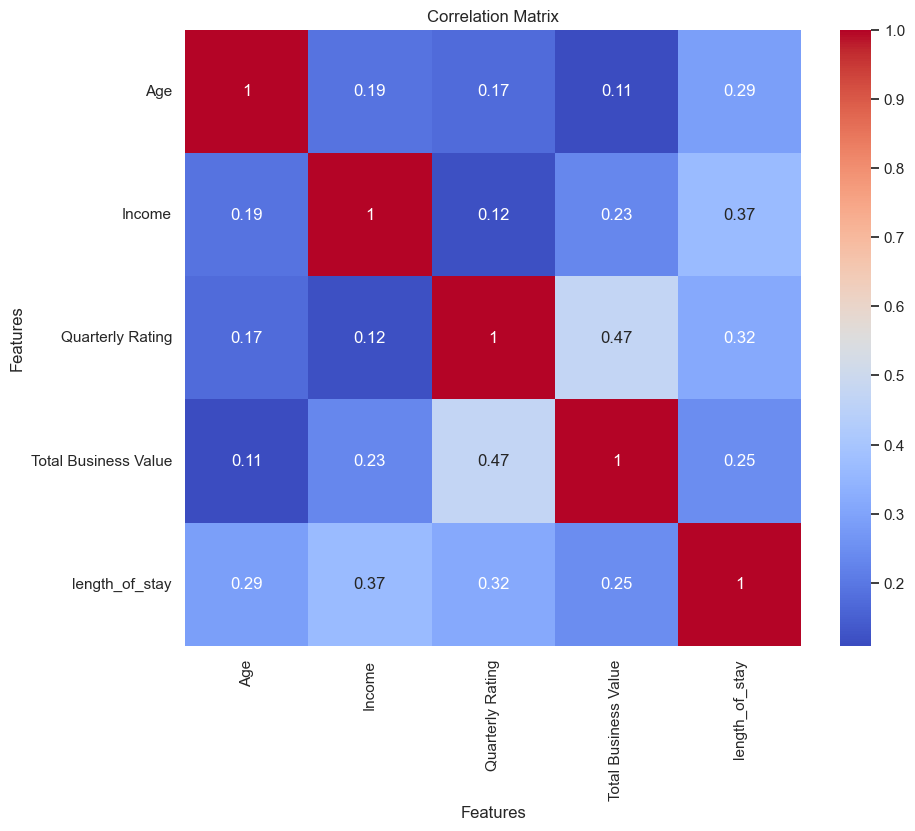

In [99]:


correlation = data[num].corr()
sns.set()  
plt.figure(figsize=(10,8))  
sns.heatmap(correlation, annot=True, cmap="coolwarm", square=True)  
plt.title('Correlation Matrix')  
plt.xlabel('Features')  
plt.ylabel('Features')  
plt.show()  

* Income is postively correlated with length of stay
* income is positively correlated with quartely rating 
* Quartely rating is positevly corlated with Total bussines value 

Is there any relation between quartely rating and age ?

In [100]:


from scipy.stats import f_oneway
temp =data.dropna()

age_zero =temp[temp['Quarterly Rating']==1]['Age'].values
age_one =temp[temp['Quarterly Rating']==2]['Age'].values
age_two =temp[temp['Quarterly Rating']==3]['Age'].values
age_three =temp[temp['Quarterly Rating']==4]['Age'].values
F, p =f_oneway(age_zero,age_one,age_two,age_three)

print('F-statistic:', F)
print('p-value:', p)

significance =0.05

Ho ='Age of all the groups are same'
ha ='Age of all the groups are not same'
if p<significance:
    print("We reject the null hypothesis",ha)
else:
    print("We fail to reject the null hypothesis" ,Ho)

F-statistic: 4.906963819216549
p-value: 0.002133274810256257
We reject the null hypothesis Age of all the groups are not same


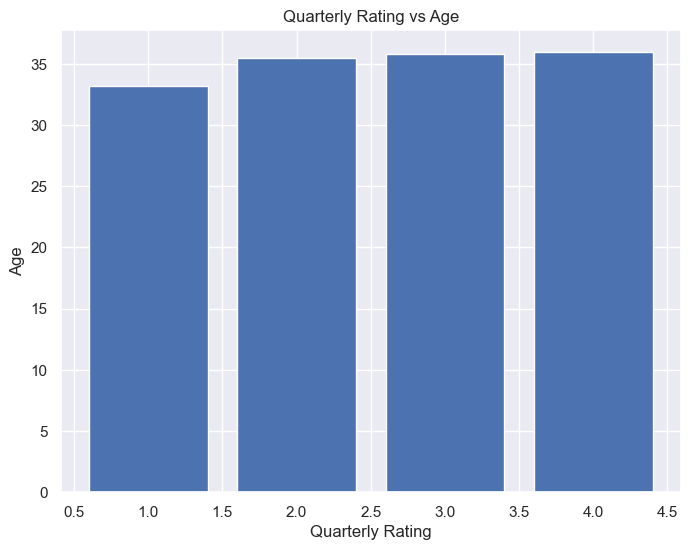

In [101]:
# plot quarterly rating vs age  scatter plot

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(data.groupby('Quarterly Rating')['Age'].mean().index, data.groupby('Quarterly Rating')['Age'].mean().values)
ax.set_title('Quarterly Rating vs Age')
ax.set_xlabel('Quarterly Rating')
ax.set_ylabel('Age')
plt.show()

* Rating 1 definetly has lower avg age 
* for rating 2,3,4 as age increase avg age does incease [35.5 , 35.8 , 35.9] 

Driver Churn bases on date of joining

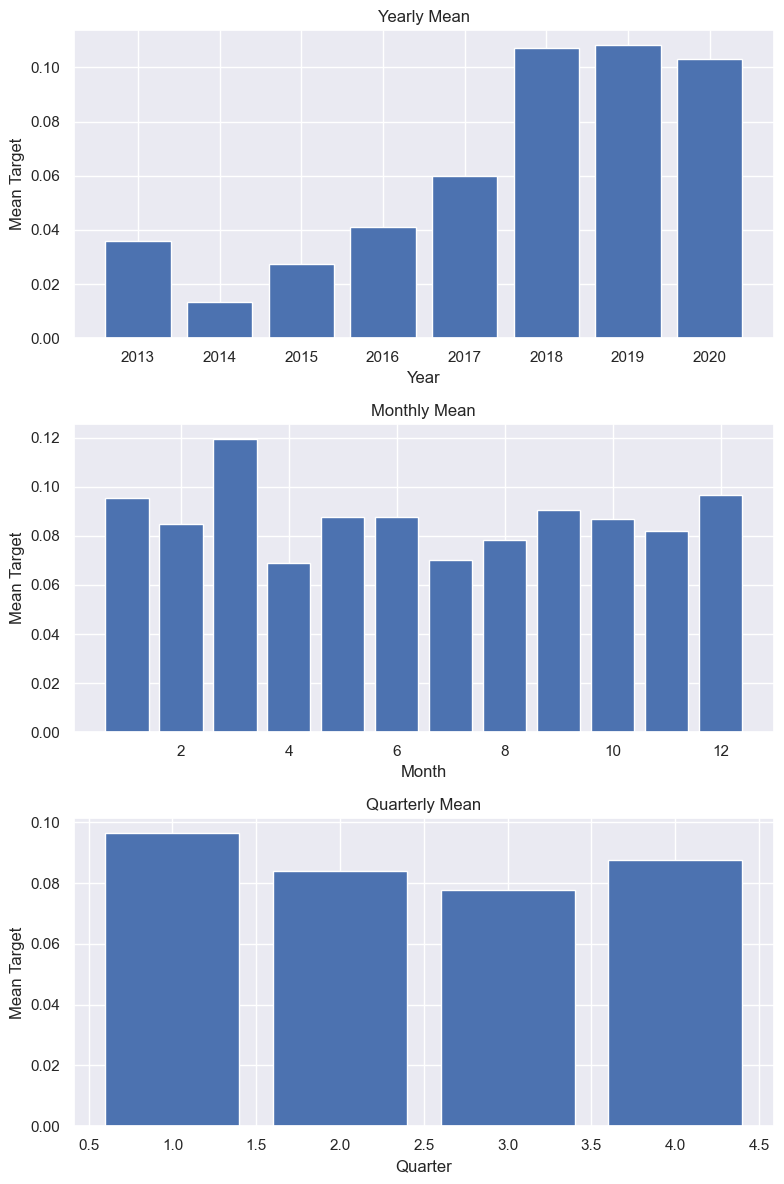

In [102]:

fig, ax = plt.subplots(3, 1, figsize=(8, 12))

ax[0].bar(data.groupby('doj_year')['target'].mean().index, data.groupby('doj_year')['target'].mean().values)
ax[0].set_title('Yearly Mean')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Mean Target')

ax[1].bar(data.groupby('doj_month')['target'].mean().index, data.groupby('doj_month')['target'].mean().values)
ax[1].set_title('Monthly Mean')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Mean Target')

ax[2].bar(data.groupby('doj_quater')['target'].mean().index, data.groupby('doj_quater')['target'].mean().values)
ax[2].set_title('Quarterly Mean')
ax[2].set_xlabel('Quarter')
ax[2].set_ylabel('Mean Target')

plt.tight_layout()
plt.show()


* churn is high for people who joined 2018 onward while in 2020 it seems to be going down 
* People who joined on first quarter churn seem to be high compared to other quarter  
*  People who joined on march churn seems to me highest 

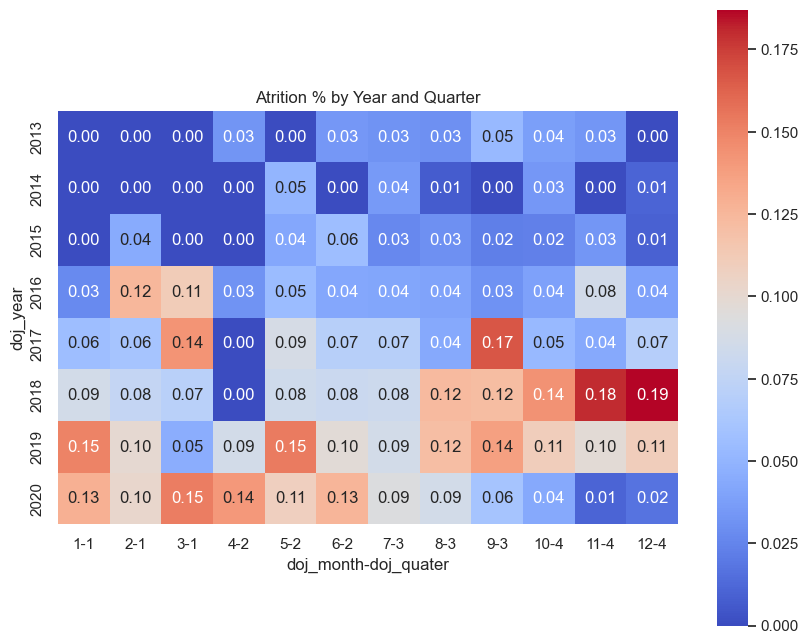

In [103]:

import matplotlib.pyplot as plt
x = data.pivot_table(index='doj_year', columns=['doj_month' ,'doj_quater'], values='target', aggfunc='mean').fillna(0)

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(10, 8))

# Use seaborn's heatmap function to create the heatmap
sns.heatmap(x, annot=True, fmt='.2f', cmap="coolwarm", square=True, ax=ax)

# Set title for the heatmap
ax.set_title('Atrition % by Year and Quarter')

# Show the plot
plt.show()

* highest churn was registered on december of 2018 
* 2020 first half year churn was high second half it went down 

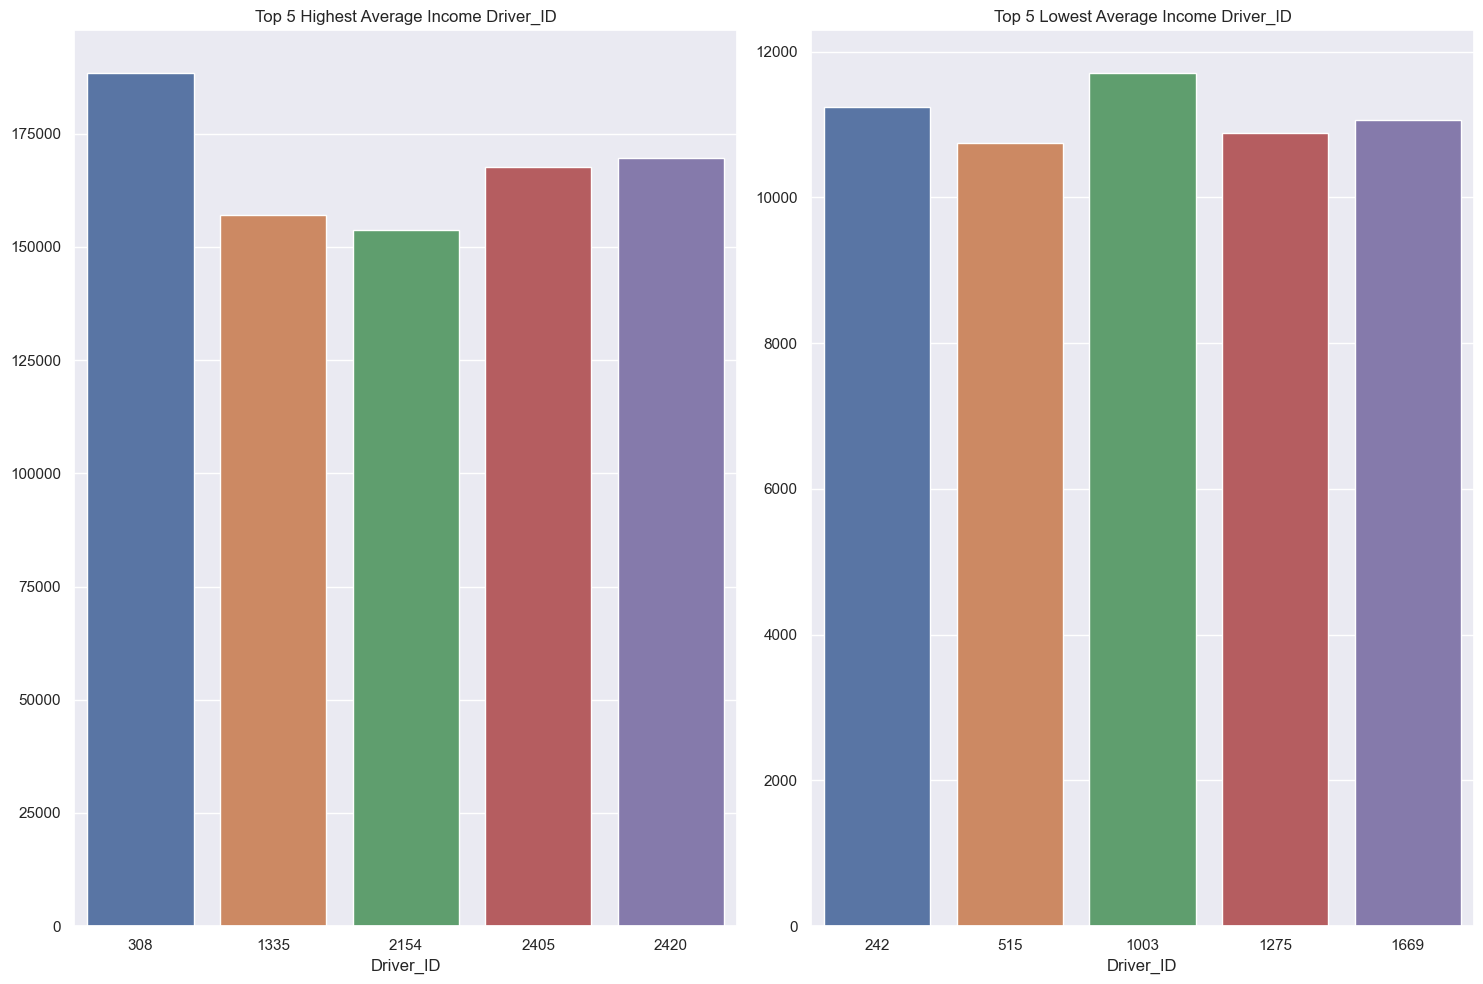

In [104]:

fig, axs = plt.subplots(1, 2, figsize=(15,10))

# Top 5 Highest Average Income Driver_ID
sns.barplot(x=data.groupby('Driver_ID')['Income'].mean().sort_values(ascending=False).head(5).index,
            y=data.groupby('Driver_ID')['Income'].mean().sort_values(ascending=False).head(5).values,
            ax=axs[0])
axs[0].set_title('Top 5 Highest Average Income Driver_ID')

# Top 5 Lowest Average Income Driver_ID
sns.barplot(x=data.groupby('Driver_ID')['Income'].mean().sort_values(ascending=True).head(5).index,
            y=data.groupby('Driver_ID')['Income'].mean().sort_values(ascending=True).head(5).values,
            ax=axs[ 1])
axs[ 1].set_title('Top 5 Lowest Average Income Driver_ID')


fig.tight_layout()
plt.show()


* Does  lenght of stay  influence churn ?

In [105]:
# do a ttest on length of stay and target
from scipy.stats import ttest_ind
temp = data[['target','length_of_stay']].dropna()
t_zero =temp[temp['target']==0]['length_of_stay']
t_one=temp[temp['target']==1]['length_of_stay']


t_stats , p  =ttest_ind(t_zero,t_one)
significance =0.05
Ho ='Mean of Length of stay of all the groups are same'
ha ='Mean of Length of stay of all the groups are not same'

if p<significance:
    print("We reject the null hypothesis",ha)
else:
    print("We fail to reject the null hypothesis" ,Ho)  


We reject the null hypothesis Mean of Length of stay of all the groups are not same


In [107]:
# do a ttest on length of stay and target
from scipy.stats import ttest_ind
temp = data[['target','Income']].dropna()
t_zero =temp[temp['target']==0]['Income']
t_one=temp[temp['target']==1]['Income']


t_stats , p  =ttest_ind(t_zero,t_one)
significance =0.05
Ho ='Mean of income of all the groups are same'
ha ='Mean of income of all the groups are not same'

if p<significance:
    print("We reject the null hypothesis",ha)
else:
    print("We fail to reject the null hypothesis" ,Ho)  

We reject the null hypothesis Mean of income of all the groups are not same


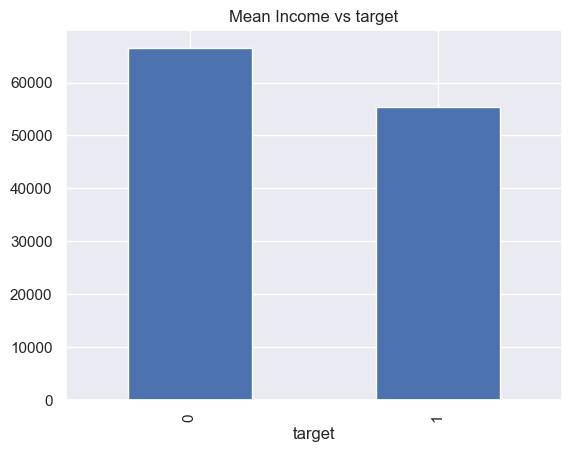

In [113]:
data.groupby('target')['Income'].mean().plot(kind='bar')
plt.title('Mean Income vs target')

plt.show()

Churned driver have lower income

In [114]:
# do a ttest on length of stay and target
from scipy.stats import ttest_ind
temp = data[['target','Total Business Value']].dropna()
t_zero =temp[temp['target']==0]['Total Business Value']
t_one=temp[temp['target']==1]['Total Business Value']


t_stats , p  =ttest_ind(t_zero,t_one)
significance =0.05
Ho ='Mean of Total Business Value of all the groups are same'
ha ='Mean of Total Business Value of all the groups are not same'

if p<significance:
    print("We reject the null hypothesis",ha)
else:
    print("We fail to reject the null hypothesis" ,Ho)  

We reject the null hypothesis Mean of Total Business Value of all the groups are not same


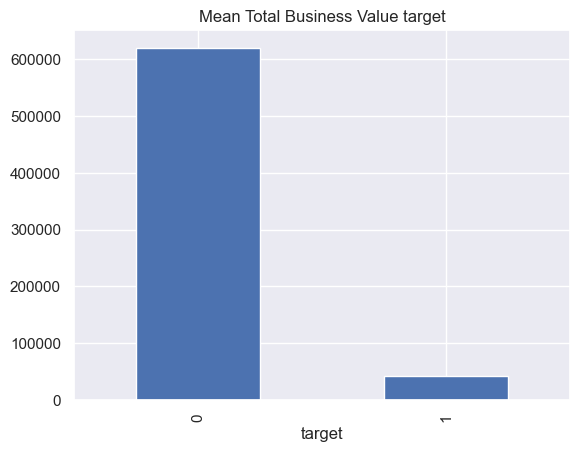

In [116]:
data.groupby('target')['Total Business Value'].mean().plot(kind='bar')
plt.title('Mean Total Business Value target')
plt.show()

Churned driver have very low Total Business Value

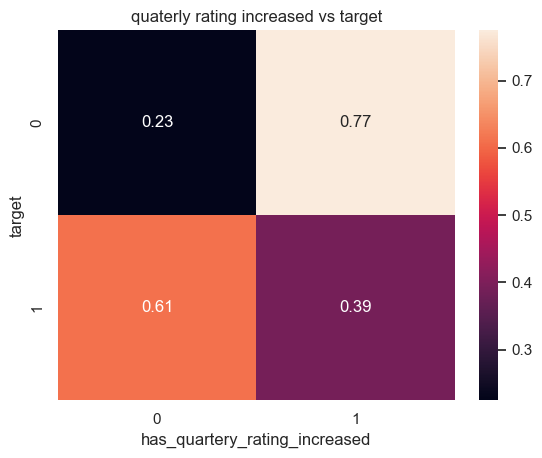

In [146]:
temp=pd.crosstab(data['target'],data['has_quartery_rating_increased'],normalize='index')
sns.heatmap(temp,annot=True)
plt.title('quaterly rating increased vs target')
plt.show()

* driver who have not churned 77% had there quarterly rating increased while for churned its 39%

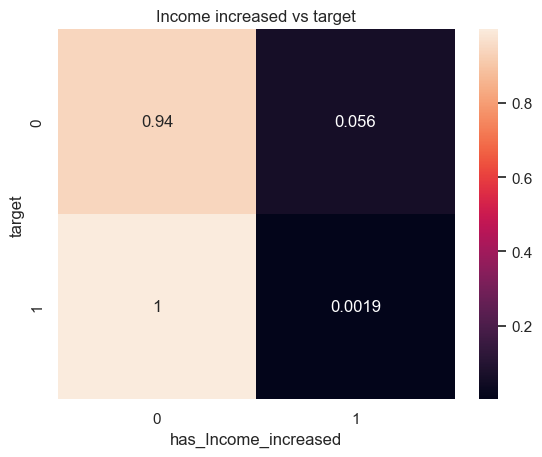

In [143]:
temp =pd.crosstab(data['target'],data['has_Income_increased'],normalize='index')
sns.heatmap(temp,annot=True)
plt.title('Income increased vs target')
plt.show()

* driver who churned less than  1% of had there income increased while for non churned its 5%

# imputation 

In [147]:

knninputer = KNNImputer()
imputation_cols =data.drop(columns=['Driver_ID']).select_dtypes('number').columns
imputed_data=knninputer.fit_transform(data[imputation_cols])
imputed_data=pd.DataFrame(imputed_data , columns= imputation_cols)
data =pd.concat([imputed_data,data[['Driver_ID','City']]],axis=1)
display(data.isna().sum())


Age                              0
Gender                           0
Education_Level                  0
Income                           0
Joining Designation              0
Grade                            0
Total Business Value             0
Quarterly Rating                 0
target                           0
has_quartery_rating_increased    0
has_Income_increased             0
length_of_stay                   0
doj_year                         0
doj_month                        0
doj_quater                       0
Driver_ID                        0
City                             0
dtype: int64

# data roleback 

In [148]:
def mode_fn(x):
    return x.value_counts().index[0]

def impute_indicator(x):
    try:
        if np.count_nonzero(x) >=1:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        print(x)
    
mapper ={ 
         'Age' : np.mean,
         'Gender' : mode_fn, 
         'City'  :mode_fn,
         'Education_Level' : mode_fn, 
         'Income':np.mean,  
        'Joining Designation':mode_fn,
        'Grade':mode_fn,
        'Total Business Value':np.sum,
        'Quarterly Rating':np.mean,
        'target' : impute_indicator,
        'has_quartery_rating_increased' : impute_indicator,
        'has_Income_increased' : impute_indicator,
        'length_of_stay' : np.mean,
         'Education_Level' : mode_fn, 
        'doj_year' :mode_fn ,
        'doj_month' : mode_fn,
        'doj_quater' : mode_fn
                  }

agg_data =data.groupby('Driver_ID').agg(mapper).reset_index()
agg_data.drop(columns=['Driver_ID'],inplace=True , axis=1)

X = agg_data.drop(columns=['target'])
y = agg_data['target']

In [149]:
cat.extend(['doj_year','doj_month','doj_quater', 'Quarterly Rating','has_quartery_rating_increased','has_Income_increased' ,'City'])

if len(num) + len(cat) != len(mapper):
    raise Exception('columns number are not same')
else:
    print('ok')

ok


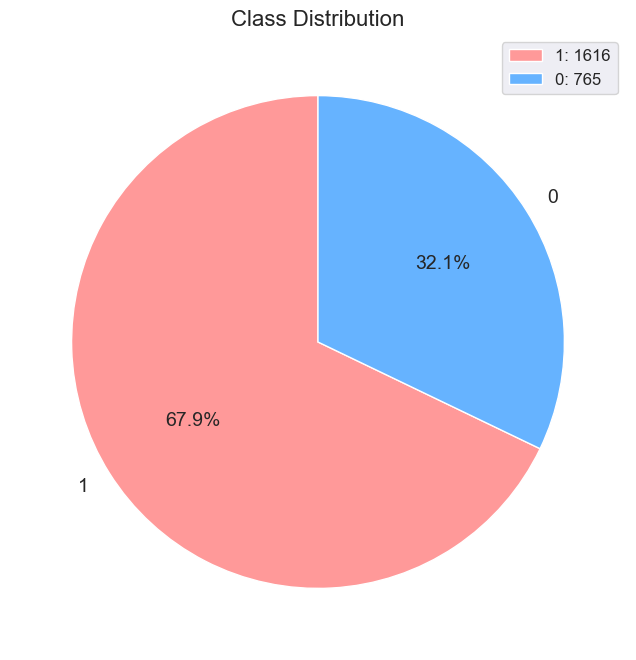

In [150]:
value_counts = y.value_counts(normalize=True)
plt.figure(figsize=(8, 8))
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], textprops={'fontsize': 14})
plt.ylabel('')  
plt.title('Class Distribution', fontsize=16)


counts = y.value_counts()
labels = [f'{i}: {counts[i]}' for i in counts.index]
plt.legend(labels, loc='upper right', fontsize=12)


plt.show()

* traget distribution 68% churn and 32% not churm 

# Train test split

In [151]:


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)



# Misc functions 

In [152]:


def ploting_roc_curve(fpr,tpr , title ="Train AUC-ROC Curve"):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
    
def roc_curve_misc(train_pred_proba,y_train  , test_pred_proba ,y_test):

    fpr, tpr, _ = roc_curve(y_train, train_pred_proba)
    print(f"Train AUC-ROC score : {roc_auc_score(y_train, train_pred_proba)}")
    ploting_roc_curve(fpr,tpr , title ="Train AUC-ROC Curve")
    fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
    print(f"Test AUC-ROC score : {roc_auc_score(y_test, test_pred_proba)}")
    ploting_roc_curve(fpr,tpr , title ="test AUC-ROC Curve")
    



def misc_metrics(X_train , X_test , y_train , y_test , pipeline):
    train_pred =pipeline.predict(X_train)
    test_pred  = pipeline.predict(X_test)
    # probality of +ve class (1)
    train_pred_proba = pipeline.predict_proba(X_train)[:,1]
    test_pred_proba  = pipeline.predict_proba(X_test)[:,1]
    pipeline.score(X_train, y_train),pipeline.score(X_test, y_test)

    train_report = classification_report(y_train, train_pred ,target_names = ['0','1'])
    test_report = classification_report(y_test, test_pred ,target_names = ['0','1'])
    print("*"*30,'Train Report')
    print(train_report)
    print("*"*30,'Test Report')
    print(test_report)
    roc_curve_misc(train_pred_proba,y_train  , test_pred_proba ,y_test)
    

# Random forest 

In [153]:



param_grid = {
    'rf__n_estimators': [10, 50, 100 , 150 , 200 ,250 ,300],
    'rf__max_depth': [5,7, 10],
    'rf__min_samples_split': [ 10 ,15, 20],
    'rf__min_samples_leaf': [5, 10 ,20],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__criterion': ['gini', 'entropy']
}


pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            
            ('std_scaler', StandardScaler(), num),
            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), cat)
            
        ]
    )),
    ('rf', RandomForestClassifier())  # Add Random Forest classifier
])

# tune random forest model 
clf = RandomizedSearchCV(pipeline, param_grid,n_iter=10 ,scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1 ,return_train_score=True)
clf.fit(X_train, y_train)
res = clf.cv_results_
for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featur

Parameters:{'rf__n_estimators': 10, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 20, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__criterion': 'gini'} Mean_score: 0.7749222396858436 Rank: 10
Parameters:{'rf__n_estimators': 250, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__max_depth': 7, 'rf__criterion': 'gini'} Mean_score: 0.8376154604968166 Rank: 4
Parameters:{'rf__n_estimators': 50, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 10, 'rf__max_features': 'auto', 'rf__max_depth': 7, 'rf__criterion': 'entropy'} Mean_score: 0.8395022395914457 Rank: 3
Parameters:{'rf__n_estimators': 100, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 10, 'rf__max_features': 'auto', 'rf__max_depth': 10, 'rf__criterion': 'entropy'} Mean_score: 0.8514058215217895 Rank: 2
Parameters:{'rf__n_estimators': 10, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__max_depth': 5, 'rf__criterion': 'gini'} Mea

****************************** Train Report
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       512
           1       0.88      0.96      0.92      1083

    accuracy                           0.89      1595
   macro avg       0.89      0.85      0.86      1595
weighted avg       0.89      0.89      0.88      1595

****************************** Test Report
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       253
           1       0.88      0.95      0.91       533

    accuracy                           0.88       786
   macro avg       0.88      0.83      0.85       786
weighted avg       0.88      0.88      0.87       786

Train AUC-ROC score : 0.9616426448522624


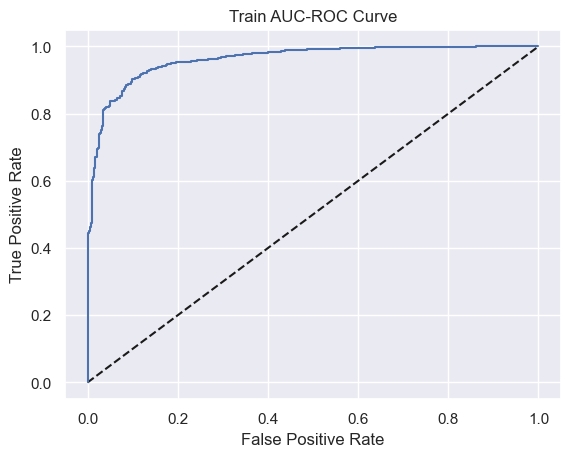

Test AUC-ROC score : 0.9489058131688036


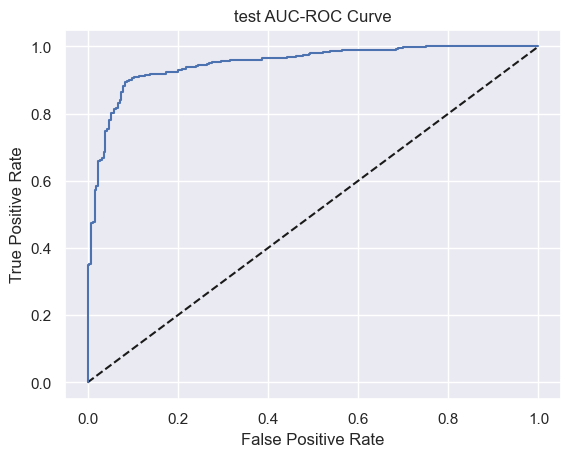

In [154]:
# find best parameters model 
best_params =clf.best_params_
# fit pipeline with best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)  
misc_metrics(X_train , X_test , y_train , y_test , pipeline   )

# Random forest model : Model 1
* Train accuracy is 90%  test accuray is 87%
* Train and test precision for both train and test is very good 90% and 87% repectively 
* Train model recall is low for minority class 0 : 76%
* Test model recall is low for minority class 0 : 70%  
* In both Train and test false negative is high for mimority class 
* AUC score for both Train and Test model is high 96% and 94% respectively model has good discrimination capability
* lets address this by fitting XGboost

* High Sensitivity: The model can correctly identify a large portion of positive instances as positive (true positive rate). This means the model has a lower chance of missing important positive cases.

* Low False Positive Rate: The model produces fewer false alarms or incorrectly predicts negative instances as positive (false positive rate). A lower false positive rate indicates that the model is making fewer mistakes when labeling negative cases as positive.

* Better Trade-off: The model achieves a good balance between sensitivity and specificity, allowing it to make informed decisions about unseen data. It can effectively separate the classes while minimizing misclassifications.



# Xgboost

In [155]:


param_grid = {
    'rf__n_estimators': [10, 50, 100 , 150 , 200 ,250 ,300],
    'rf__max_depth': [1,3],
    'rf__min_samples_leaf': [10 , 20, 30],
    'rf__colsample_bytree': [0.3, 0.5, 0.7],
    'rf__eta':[0.01 , 0.03, 0.05, 0.07],
    'rf__subsample': [0.3, 0.5, 0.7],
    
}


pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            
            ('std_scaler', StandardScaler(), num),
            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), cat)
            
        ]
    )),
    ('rf', XGBClassifier()) 
])


clf = RandomizedSearchCV(pipeline, param_grid,n_iter=10 ,scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1 ,return_train_score=True)
clf.fit(X_train, y_train)
res = clf.cv_results_
for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:25:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:25:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:25:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:25:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } ar

Parameters:{'rf__subsample': 0.5, 'rf__n_estimators': 10, 'rf__min_samples_leaf': 30, 'rf__max_depth': 3, 'rf__eta': 0.03, 'rf__colsample_bytree': 0.5} Mean_score: 0.6789973993363825 Rank: 9
Parameters:{'rf__subsample': 0.7, 'rf__n_estimators': 100, 'rf__min_samples_leaf': 30, 'rf__max_depth': 3, 'rf__eta': 0.03, 'rf__colsample_bytree': 0.5} Mean_score: 0.8771151041445422 Rank: 3
Parameters:{'rf__subsample': 0.5, 'rf__n_estimators': 250, 'rf__min_samples_leaf': 10, 'rf__max_depth': 3, 'rf__eta': 0.01, 'rf__colsample_bytree': 0.3} Mean_score: 0.8702157937215921 Rank: 5
Parameters:{'rf__subsample': 0.7, 'rf__n_estimators': 300, 'rf__min_samples_leaf': 20, 'rf__max_depth': 1, 'rf__eta': 0.03, 'rf__colsample_bytree': 0.3} Mean_score: 0.8608102176344817 Rank: 6
Parameters:{'rf__subsample': 0.7, 'rf__n_estimators': 50, 'rf__min_samples_leaf': 10, 'rf__max_depth': 1, 'rf__eta': 0.03, 'rf__colsample_bytree': 0.3} Mean_score: 0.7097050535944381 Rank: 8
Parameters:{'rf__subsample': 0.3, 'rf__n_e

****************************** Train Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       512
           1       0.94      0.94      0.94      1083

    accuracy                           0.91      1595
   macro avg       0.90      0.90      0.90      1595
weighted avg       0.91      0.91      0.91      1595

****************************** Test Report
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       253
           1       0.93      0.94      0.93       533

    accuracy                           0.91       786
   macro avg       0.90      0.89      0.89       786
weighted avg       0.91      0.91      0.91       786

Train AUC-ROC score : 0.9698194396352724


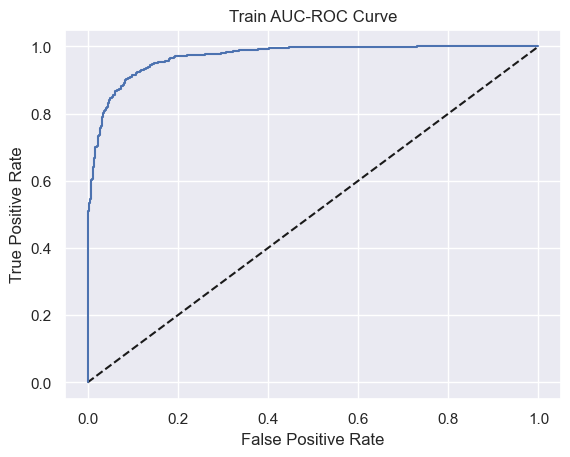

Test AUC-ROC score : 0.953407144287314


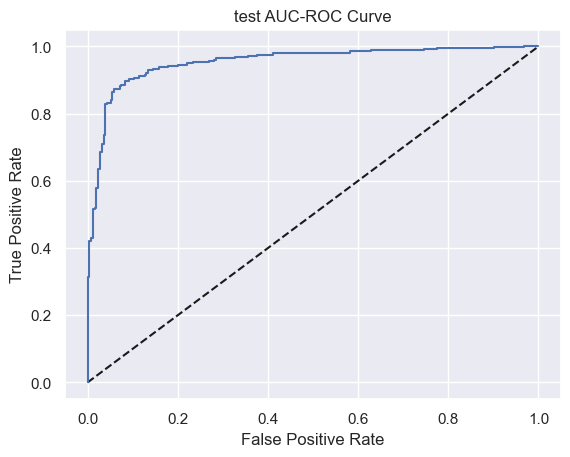

In [156]:
# find best parameters model 
best_params =clf.best_params_
# fit pipeline with best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)  
misc_metrics(X_train , X_test , y_train , y_test , pipeline   )

# xgboost (model 2)
* Train accuracy is 91%  test accuray is 90%
* Train precision class 0 is 87% for class 1 is 92%
* Test precision class 0 is 86% for class 1 is 93%
* Train recall class 0 is 84% for class 1 is 94%
* Test recall class 0 is 82% for class 1 is 94%
* Recall is Still lower for both train and test but surely lot better than random forest model  
* AUC score for both Train and Test model is high 96% and 95% respectively model has good discrimination capability
* lets address this by oversampling data 

# oversampling pipeline  with xgboost

In [157]:


param_grid = {
    'rf__n_estimators': [10, 50, 100 , 150 , 200 ,250 ,300],
    'rf__max_depth': [1,3],
    'rf__min_samples_leaf': [10 , 20, 30],
    'rf__colsample_bytree': [0.3, 0.5, 0.7],
    'rf__eta':[0.01 , 0.03, 0.05, 0.07],
    'rf__subsample': [0.3, 0.5, 0.7],
    
}


preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), num),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), cat)
    ]
)

# Define the pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),

    ('rf', XGBClassifier())
])
# tune random forest model 
clf = RandomizedSearchCV(pipeline, param_grid,n_iter=10 ,scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1 ,return_train_score=True)
clf.fit(X_train, y_train)
res = clf.cv_results_
for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aditya/miniconda3/envs/pytorch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } ar

Parameters:{'rf__subsample': 0.7, 'rf__n_estimators': 150, 'rf__min_samples_leaf': 20, 'rf__max_depth': 3, 'rf__eta': 0.03, 'rf__colsample_bytree': 0.7} Mean_score: 0.8758714111078071 Rank: 3
Parameters:{'rf__subsample': 0.7, 'rf__n_estimators': 200, 'rf__min_samples_leaf': 20, 'rf__max_depth': 1, 'rf__eta': 0.01, 'rf__colsample_bytree': 0.3} Mean_score: 0.8401323459307403 Rank: 7
Parameters:{'rf__subsample': 0.5, 'rf__n_estimators': 10, 'rf__min_samples_leaf': 20, 'rf__max_depth': 3, 'rf__eta': 0.05, 'rf__colsample_bytree': 0.7} Mean_score: 0.8551711198901207 Rank: 5
Parameters:{'rf__subsample': 0.5, 'rf__n_estimators': 300, 'rf__min_samples_leaf': 30, 'rf__max_depth': 3, 'rf__eta': 0.07, 'rf__colsample_bytree': 0.7} Mean_score: 0.8827671816075028 Rank: 1
Parameters:{'rf__subsample': 0.5, 'rf__n_estimators': 250, 'rf__min_samples_leaf': 10, 'rf__max_depth': 1, 'rf__eta': 0.01, 'rf__colsample_bytree': 0.7} Mean_score: 0.8137681775059117 Rank: 10
Parameters:{'rf__subsample': 0.5, 'rf__n

****************************** Train Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       512
           1       0.96      0.95      0.95      1083

    accuracy                           0.93      1595
   macro avg       0.92      0.93      0.93      1595
weighted avg       0.94      0.93      0.94      1595

****************************** Test Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       253
           1       0.93      0.93      0.93       533

    accuracy                           0.91       786
   macro avg       0.89      0.89      0.89       786
weighted avg       0.91      0.91      0.91       786

Train AUC-ROC score : 0.9839043022853184


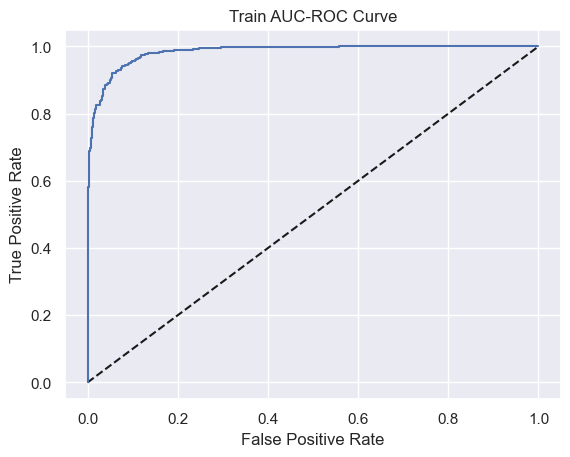

Test AUC-ROC score : 0.9572113994171259


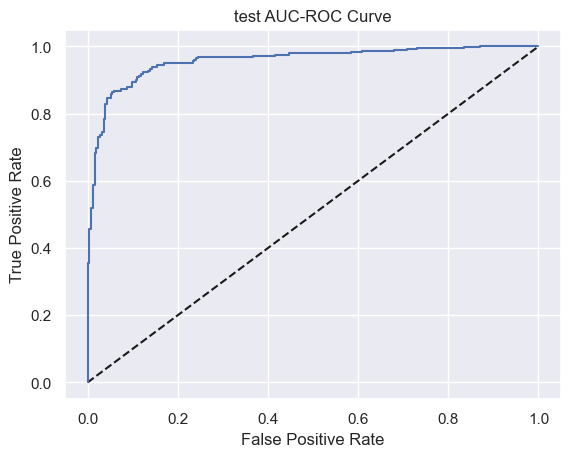

In [158]:
# find best parameters model 
best_params =clf.best_params_
# fit pipeline with best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)  
misc_metrics(X_train , X_test , y_train , y_test , pipeline   )

# Oversampled Xgboost (model 3)
* Train accuracy is 91%  test accuray is 90%
* Train precision class 0 is 83% for class 1 is 95% -- precision has gone down in both case compared to model X
* Test precision class 0 is 86% for class 1 is 93% -- test its almost same
* Train recall class 0 is 89% for class 1 is 92% -- recall of minority class has gone up and majority has gone down but not by a lot 
* Test recall class 0 is 86% for class 1 is 92% -- recall of minority class has gone up and majority has gone down but not by a lot 
* Over sampled model performance precision and recall seems very simlar  
* AUC score for both Train and Test model is high 96% and 95% respectively model has good discrimination capability
# So far this is the best model

# Recommendations 

- Decrease in driver reporting annually necessitates strategies to attract more drivers to Ola.
- Mean income has been declining year after year; 2018 marked the lowest point. Since 2019, mean income appears to have plateaued, indicating the need to explore methods to raise driver earnings.
- It's imperative to educate drivers to enhance their quarterly ratings, as this directly impacts their income. Particularly focus on educating younger drivers, as they tend to receive lower ratings.
